In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from numba import jit
from scipy.optimize import curve_fit

import simple_CMD
import utils

In [2]:
@jit(nopython=True)
def mildly_anharmonic_potential(x):
    '''
    A common used anharmonic potential

    V(x) = 0.5*x^2 + 0.1*x^3 + 0.01*x^4

    https://doi.org/10.1063/1.3126950
    '''
    return 0.5 * x**2 + 0.1 * x**3 + 0.01 * x**4

Solve the quantum system first:

In [ ]:
energies, wavefunctions, xx = utils.quantum.solve_sinc_dvr(
    mildly_anharmonic_potential, N_states=20, N_grids=1025, bound=(-10, 10), mass=1.0)
x_matrix = scipy.integrate.romb(
    np.einsum(
        'ij, ik, i -> ijk',
        wavefunctions,
        wavefunctions,
        xx),
    dx=xx[1] - xx[0],
    axis=0)
x_matrix = (x_matrix + x_matrix.T) / 2  # symmetrize

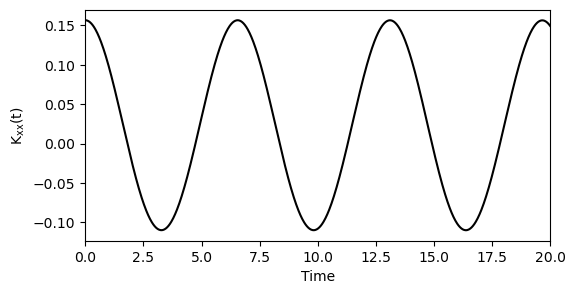

In [ ]:
time = np.linspace(0, 20, 1000)
posKubo_corr = utils.quantum.get_Kubo_correlation(
    time, energies, x_matrix, x_matrix, beta=8.0)
plt.figure(figsize=(6, 3))
plt.plot(time, posKubo_corr.real, color='black', label='Exact')
plt.xlabel('Time')
plt.ylabel('K$_\\mathrm{xx}$(t)')
plt.xlim(0, 20)
plt.show()

In [5]:
@jit(nopython=True)
def CMD_potential(x, a0, a1, a2, a3, a4, a5, a6):
    '''
    6th order polynomial potential used in CMD fitting

    Note we force the coefficient of x^4 and x^6 to be positive for stability
    '''
    return a0 + a1 * x + a2 * x**2 + a3 * x**3 + \
        a4**2 * x**4 + a5 * x**5 + a6**2 * x**6


@jit(nopython=True)
def CMD_dV(x, a0, a1, a2, a3, a4, a5, a6):
    return a1 + 2 * a2 * x + 3 * a3 * x**2 + 4 * \
        a4**2 * x**3 + 5 * a5 * x**4 + 6 * a6**2 * x**5

Next, we sample the CMD potential using PIMC:

In [6]:
@jit(nopython=True)
def callback(path):
    # https://doi.org/10.1063/1.479514 Eq. 16
    return np.mean(path)


means = simple_CMD.pimc_sample(
    N_beads=32,
    step_size=2,
    potential=mildly_anharmonic_potential,
    mass=1,
    beta=8,
    callback=callback,
    n_iterations=10000,
    n_sweeps=2000,
    burn_in=1000)
means = np.array(means)

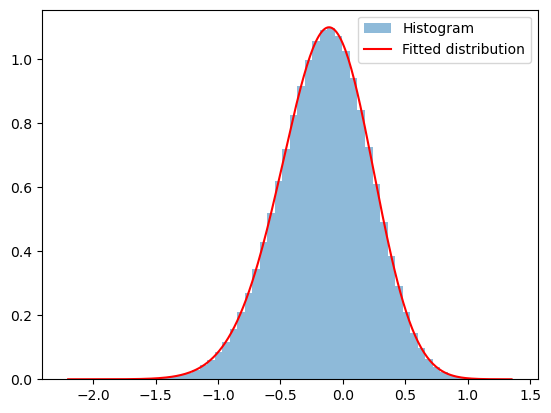

In [7]:
def exp_poly6(x, a0, a1, a2, a3, a4, a5, a6):
    # The centroid distribution is exp(-beta*V_CMD(x))/Z
    return np.exp(-8 * CMD_potential(x, a0, a1, a2, a3, a4, a5, a6))


counts, bins = np.histogram(means, bins=60, density=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

CMD_parameter, _ = curve_fit(
    exp_poly6, bin_centers, counts, p0=-0.1 * np.ones(7))

plt.hist(means, bins=60, density=True, alpha=0.5, label='Histogram')
x_fit = np.linspace(bin_centers.min(), bin_centers.max(), 300)
plt.plot(
    x_fit,
    exp_poly6(
        x_fit,
        *CMD_parameter),
    'r-',
    label='Fitted distribution')
plt.legend()
plt.show()

CMD is exact at t=0. So we expect the sampled value to match the exact value.

In [8]:
print('Sampled value:', (means**2).mean())
print('Exact value', posKubo_corr[0].real)

Sampled value: 0.15533423854381828
Exact value 0.15649775096028096


Note the following is redundant since we could just use the sampled means above

We include it here to show how to use MCMC to sample initial configurations for general 1-D potentials

You may easily modify it to other potentials

In [ ]:

para = tuple(CMD_parameter)


@jit(nopython=True)
def CMD_V_func(x):
    return CMD_potential(x, para[0], para[1], para[2],
                         para[3], para[4], para[5], para[6])


beta = 8
mass = 1
n_samples = 1000000

samples_x = utils.classical.run_metropolis_sampling(
    n_samples=n_samples,
    potential=CMD_V_func,
    step_size=1,
    beta=beta,
    burn_in=10000,
    star_x=0)

sigma_p = np.sqrt(mass / beta)
samples_p = np.random.normal(loc=0, scale=sigma_p, size=n_samples)

Acceptance rate:  52.4765 %


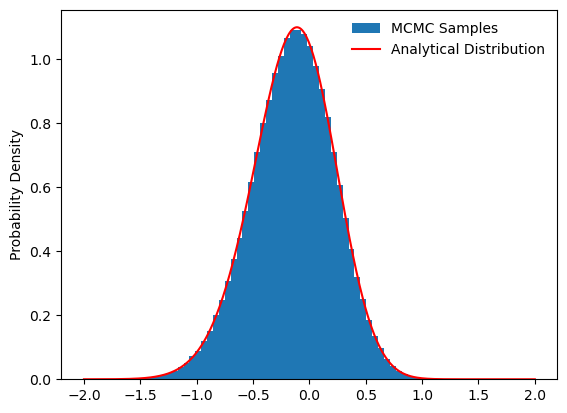

In [10]:
from scipy.integrate import quad

plt.hist(samples_x, bins=60, density=True, label='MCMC Samples')

# Our sampled distribution agrees well with the analytical distribution
x_vals = np.linspace(-2.0, 2.0, 400)
prob_x = np.exp(-beta * CMD_V_func(x_vals))
Z_x, _ = quad(lambda x: np.exp(-beta * CMD_V_func(x)), -2, 2)
plt.plot(x_vals, prob_x / Z_x, 'r', label='Analytical Distribution')
plt.ylabel('Probability Density')
plt.legend(frameon=False)
plt.show()

Time to run CMD simulation with the fitted potential!

In [ ]:
para = tuple(CMD_parameter)


@jit(nopython=True)
def CMD_dV_func(x):
    return CMD_dV(x, para[0], para[1], para[2],
                  para[3], para[4], para[5], para[6])


selected_indices = np.random.choice(len(samples_x), size=10000, replace=False)
samples_x = np.array([samples_x[i] for i in selected_indices])
samples_p = np.array([samples_p[i] for i in selected_indices])
traj_CMD = utils.classical.run_nve_simulation(
    samples_x, samples_p / mass, 1, CMD_dV_func, 0.01, 2000)

In [12]:
def calc_ACF(traj, traj2=None):
    'calculate auto-correlation functions'
    # https://github.com/theorychemyang/pyscf/blob/80b77132dac4e084390638886cab61902dbe3c0c/pyscf/neo/md.py
    if traj2 is None:
        traj2 = traj
    autocorr = scipy.signal.correlate(traj, traj2, mode='full')[len(traj) - 1:]
    autocorr = np.multiply(autocorr, 1 / np.arange(len(traj), 0, -1))
    return autocorr


autocorr_CMD = 0
for i in (traj_CMD).T:
    autocorr_CMD += calc_ACF(i)

Check Figure 7 from the paper by Pérez, Tuckerman and Müser:

> *A comparative study of the centroid and ring-polymer molecular dynamics methods for approximating quantum time correlation functions from path integrals.* [J. Chem. Phys. 130, 184105 (2009)](https://doi.org/10.1063/1.3126950)


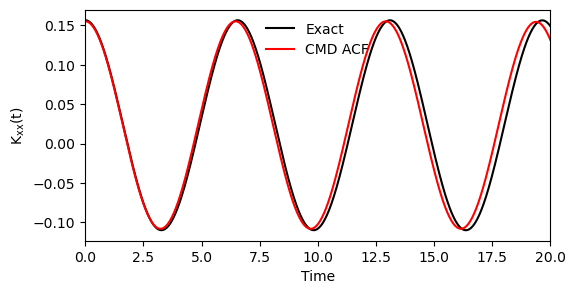

In [13]:
plt.figure(figsize=(6, 3))

plt.plot(time, posKubo_corr.real, color='black', label='Exact')
plt.plot(
    np.linspace(
        0,
        20,
        len(autocorr_CMD)),
    autocorr_CMD /
    traj_CMD.shape[1],
    color='red',
    label='CMD ACF')
plt.xlabel('Time')
plt.ylabel('K$_\\mathrm{xx}$(t)')
plt.xlim(0, 20)
plt.legend(frameon=False)
plt.show()